In [242]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [243]:
df = pd.read_csv('data/Data4Good_Arolsen_Archives_50k.csv')
df = df.sample(n=3000, random_state=42).reset_index(drop=True)

In [244]:
pd.set_option('display.max_columns', None)

In [245]:
df.columns

Index(['Unnamed: 0', 'Last_Name', 'First Name', 'Alternative Name',
       'Father (Vater - Eltern)', 'Mother (Mutter - Eltern)',
       'Spouse (Ehem/Ehefr)', 'Birthdate (Geb)', 'Alternative_Birthdate',
       'Birth Place', 'TD', 'Nationality', 'Alternative Nationality 1',
       'Alternative Nationality 2', 'Religion', 'Upper', 'Middle',
       'Geo Location', 'Inferred Nationality', 'Overall Confidence OCR',
       'Automatic Validation', 'Volunteers' Comment'],
      dtype='object')

In [246]:
# Ensure all values are strings and replace double double-quotes
df["Geo Location"] = df["Geo Location"].astype(str).apply(lambda x: x.replace('""', '"'))
# Ensure values are strings and remove surrounding quotes
df["Geo Location"] = df["Geo Location"].astype(str).apply(lambda x: x.strip('"'))
# Ensure values are strings and remove surrounding single and double quotes
df["Geo Location"] = df["Geo Location"].astype(str).apply(lambda x: x.strip("'").strip('"'))



In [247]:
df["Geo Location"][1]

'{"paths":[{"fromLabel":"Kolocava CSR","toLabel":"Seklence","index":0,"type":""},{"fromLabel":"Seklence","toLabel":"Auschw","index":1,"type":""},{"fromLabel":"Auschw","toLabel":"Stutthof","index":2,"type":""},{"fromLabel":"Stutthof","toLabel":"Putzig","index":3,"type":""},{"fromLabel":"Putzig","toLabel":"Putzig","index":4,"type":""}],"markers":[{"location":{"lon":23.7371118,"lat":48.418023},"label":"Kolocava CSR","type":"Birth Place"},{"label":"Seklence","type":"Location"},{"label":"Auschw","type":"Location"},{"location":{"lon":19.1790706,"lat":54.3260845},"label":"Stutthof","type":"Location"},{"location":{"lon":18.4086339,"lat":54.71804770000001},"label":"Putzig","type":"Location"},{"location":{"lon":18.4086339,"lat":54.71804770000001},"label":"Putzig","type":"Location"}]}'

In [248]:
# import json
# import pandas as pd

# # Function to safely extract max index
# def get_max_index(json_str):
#     try:
#         data = json.loads(json_str)
#         paths = data.get("paths", [])
#         if paths:  # Ensure paths is not empty
#             return max(item["index"] for item in paths)
#         return -1  # Return -1 if paths is empty
#     except (json.JSONDecodeError, KeyError, TypeError):
#         return -1  # Return -1 if the structure is invalid

# Apply function to DataFrame
# df["max_index"] = df["Geo Location"].apply(get_max_index)

In [249]:
df.columns

Index(['Unnamed: 0', 'Last_Name', 'First Name', 'Alternative Name',
       'Father (Vater - Eltern)', 'Mother (Mutter - Eltern)',
       'Spouse (Ehem/Ehefr)', 'Birthdate (Geb)', 'Alternative_Birthdate',
       'Birth Place', 'TD', 'Nationality', 'Alternative Nationality 1',
       'Alternative Nationality 2', 'Religion', 'Upper', 'Middle',
       'Geo Location', 'Inferred Nationality', 'Overall Confidence OCR',
       'Automatic Validation', 'Volunteers' Comment'],
      dtype='object')

In [250]:
df = df.drop(columns=["Unnamed: 0", "Last_Name", "First Name", "TD", "Alternative Name", "Father (Vater - Eltern)", "Mother (Mutter - Eltern)", "Spouse (Ehem/Ehefr)", "Upper", "Middle", "Volunteers' Comment", "Overall Confidence OCR", "Alternative Nationality 2", "Alternative Nationality 1"])

# Convert to string to avoid errors
df['Birthdate (Geb)'] = df['Birthdate (Geb)'].astype(str)

# Function to split birthdate into components
def split_birthdate(date):
    if date.startswith('//'):  # Case: Birthdate starts with "//"
        return date[2:], np.nan, np.nan  # Extract year, set Month and Day to 0
    
    parts = date.split('/')
    
    if len(parts) == 3:  # Full date case (DD/MM/YYYY)
        return parts[2], parts[1], parts[0]  # Year, Month, Day
    elif len(parts) == 1 and date.isdigit() and len(date) == 4:  # Year only (YYYY)
        return date, np.nan, np.nan  # Set Month and Day to 0
    else:
        return None, None, None  # Handle missing or invalid values

# Apply function to create new columns
df[['Birth_Year', 'Birth_Month', 'Birth_Day']] = df['Birthdate (Geb)'].apply(lambda x: pd.Series(split_birthdate(x)))

# Convert numeric columns to integers where possible
df['Birth_Year'] = pd.to_numeric(df['Birth_Year'], errors='coerce')
df['Birth_Month'] = pd.to_numeric(df['Birth_Month'], errors='coerce')
df['Birth_Day'] = pd.to_numeric(df['Birth_Day'], errors='coerce')

df['Birth_Month'] = np.where(df['Birth_Month'] > 12, np.nan, df['Birth_Month'])
df['Birth_Day'] = np.where(df['Birth_Day'] > 31, np.nan, df['Birth_Day'])    

df['Birth_Year'] = np.where(df['Birth_Year'] < 1800, np.nan, df['Birth_Year'])
df['Birth_Year'] = np.where(df['Birth_Year'] > 1945, np.nan, df['Birth_Year'])

df.drop(columns=['Birthdate (Geb)', 'Alternative_Birthdate'], inplace=True)

df['Religion'] = df['Religion'].replace({
    'Orthodox Christian Christian Christian Christian Christian': 'Orthodox Christian'
})

# Group rare religions
min_count = 5  # Threshold for rare categories
religion_counts = df['Religion'].value_counts()
rare_religions = religion_counts[religion_counts < min_count].index
df['Religion'] = df['Religion'].replace(rare_religions, 'Other')

df = pd.get_dummies(df, columns=['Religion'], prefix='Religion')
print(df.columns)

# Convert boolean columns to integers
religion_columns = [col for col in df.columns if col.startswith('Religion_')]
df[religion_columns] = df[religion_columns].astype(int)

df['Automatic Validation'].isna().sum()
df['Automatic Validation'] = df['Automatic Validation'].fillna('Unknown')


Index(['Birth Place', 'Nationality', 'Geo Location', 'Inferred Nationality',
       'Automatic Validation', 'Birth_Year', 'Birth_Month', 'Birth_Day',
       'Religion_Jewish', 'Religion_Other', 'Religion_Roman Catholic'],
      dtype='object')


In [251]:
df["Nationality"] = df["Nationality"].str.replace(r"(?i)\bFormerly\b", "", regex=True).str.strip()

df["Nationality"] = df["Nationality"].str.lower().replace(r"stateless", np.nan, regex=True)

from fuzzywuzzy import process
import pandas as pd

# Convert valid nationalities list to lowercase
valid_nationalities = [
    # Common nationalities (ISO 3166)
    "afghan", "albanian", "algerian", "american", "andorran", "angolan", "argentine", "armenian", "australian", "austrian",
    "azerbaijani", "bahamian", "bahraini", "bangladeshi", "barbadian", "belarusian", "belgian", "belizean", "beninese", "bhutanese",
    "bolivian", "bosnian", "botswanan", "brazilian", "british", "bruneian", "bulgarian", "burkinabé", "burmese", "burundian",
    "cambodian", "cameroonian", "canadian", "cape verdean", "central african", "chadian", "chilean", "chinese", "colombian",
    "comoran", "congolese", "costa rican", "croatian", "cuban", "cypriot", "czech", "danish", "djiboutian", "dominican",
    "dutch", "east timorese", "ecuadorean", "egyptian", "emirati", "equatorial guinean", "eritrean", "estonian", "eswatini",
    "ethiopian", "fijian", "finnish", "french", "gabonese", "gambian", "georgian", "german", "ghanaian", "greek",
    "grenadian", "guatemalan", "guinean", "guyanese", "haitian", "honduran", "hungarian", "icelandic", "indian", "indonesian",
    "iranian", "iraqi", "irish", "israeli", "italian", "ivorian", "jamaican", "japanese", "jordanian", "kazakh",
    "kenyan", "kiribati", "kuwaiti", "kyrgyz", "lao", "latvian", "lebanese", "lesotho", "liberian", "libyan",
    "liechtensteiner", "lithuanian", "luxembourgish", "macedonian", "malagasy", "malawian", "malaysian", "maldivian",
    "malian", "maltese", "marshallese", "mauritanian", "mauritian", "mexican", "micronesian", "moldovan", "monacan",
    "mongolian", "montenegrin", "moroccan", "mozambican", "myanmar", "namibian", "nauruan", "nepalese", "new zealander",
    "nicaraguan", "nigerian", "north korean", "norwegian", "omani", "pakistani", "palauan", "palestinian", "panamanian",
    "papua new guinean", "paraguayan", "peruvian", "philippine", "polish", "portuguese", "qatari", "romanian", "russian",
    "rwandan", "saint lucian", "salvadoran", "samoan", "saudi", "scottish", "senegalese", "serbian", "seychellois",
    "sierra leonean", "singaporean", "slovak", "slovenian", "solomon islander", "somali", "south african", "south korean",
    "south sudanese", "spanish", "sri lankan", "sudanese", "surinamese", "swedish", "swiss", "syrian", "taiwanese",
    "tajik", "tanzanian", "thai", "togolese", "tongan", "trinidadian", "tunisian", "turkish", "turkmen", "tuvaluan",
    "ugandan", "ukrainian", "uruguayan", "uzbek", "venezuelan", "vietnamese", "welsh", "yemeni", "zambian", "zimbabwean",

    # Historical nationalities
    "austro-hungarian", "prussian", "bohemian", "ottoman", "soviet", "yugoslav", "czechoslovak", "west german", "east german",
    "rhodesian", "serbo-croatian", "mandarin", "manchu", "ming", "byzantine",

    # Stateless or refugee identities
    "stateless", "refugee", "displaced", "unknown",

    # Manually added for necessity
    "yugoslavian", "ussr"
]

# Manual correction mapping for specific cases
manual_corrections = {
    "argentinian": "argentine",
    "luxembourger": "luxembourgish",
    "germna": "german",  # Common OCR mistake
    "polan": "polish"  # Common OCR mistake
}

# Convert all nationalities in data to lowercase and strip spaces
df["Nationality"] = df["Nationality"].str.lower().str.strip()

# Apply manual corrections first
df["Nationality_Corrected"] = df["Nationality"].replace(manual_corrections)

# Fuzzy matching function for remaining uncorrected values
def fuzzy_correct(nationality):
    if pd.isna(nationality):  # Skip NaN values
        return None
    match, score = process.extractOne(nationality, valid_nationalities)
    return match if score > 85 else nationality  # Keep original if match is weak

In [252]:
df.columns

Index(['Birth Place', 'Nationality', 'Geo Location', 'Inferred Nationality',
       'Automatic Validation', 'Birth_Year', 'Birth_Month', 'Birth_Day',
       'Religion_Jewish', 'Religion_Other', 'Religion_Roman Catholic',
       'Nationality_Corrected'],
      dtype='object')

In [253]:
# Apply fuzzy matching for remaining uncorrected values
df["Nationality_Corrected"] = df["Nationality_Corrected"].apply(fuzzy_correct)

# Identify cases where fuzzy matching changed the nationality
data_fuzzy_changed = df[df["Nationality"] != df["Nationality_Corrected"]]

# Print fuzzy-matched values
# print("Fuzzy-matched corrections:")
# print(data_fuzzy_changed[["Nationality", "Nationality_Corrected"]])

# Identify remaining unrecognized nationalities
unrecognized = df[~df["Nationality_Corrected"].isin(valid_nationalities)]
# print("\nRemaining Unrecognized Nationalities:")
# print(unrecognized["Nationality_Corrected"].unique())

# Find nationalities not in the valid list
valid_nationalities.append(None)
data_unrecognized = df[~df["Nationality_Corrected"].isin(valid_nationalities)]
# Show the indexes and the unrecognized nationalities
df = df[~df["Nationality_Corrected"].isin(data_unrecognized['Nationality_Corrected'])].reset_index(drop=True)

df.drop(columns=['Nationality', 'Inferred Nationality'], inplace=True)

In [254]:
from sklearn.preprocessing import LabelEncoder

# Fill None values with "unknown"
df["Nationality_Corrected"] = df["Nationality_Corrected"].fillna("unknown")

# Apply Label Encoding
label_encoder = LabelEncoder()
df["Nationality_Corrected_Encoded"] = label_encoder.fit_transform(df["Nationality_Corrected"])

df.drop(columns=['Nationality_Corrected'], inplace=True)

# Impute missing values with the mean of each column
df["Birth_Year"].fillna(df["Birth_Year"].mean(), inplace=True)
df["Birth_Month"].fillna(df["Birth_Month"].mean(), inplace=True)
df["Birth_Day"].fillna(df["Birth_Day"].mean(), inplace=True)

# Convert Birth_Year to integer (optional if you don't want decimals)
df["Birth_Year"] = df["Birth_Year"].round().astype(int)
df["Birth_Month"] = df["Birth_Month"].round().astype(int)
df["Birth_Day"] = df["Birth_Day"].round().astype(int)

# Define a mapping to ensure a consistent order
validation_mapping = {
    "Unknown": 4,
    "Matched": 3,
    "Above threshold for Last Name and TD": 2,
    "To be validated": 1,
    "Submitted": 0
}

# Apply mapping to encode the column
df["Automatic_Validation_Encoded"] = df["Automatic Validation"].map(validation_mapping).round().astype(int)
df.drop(columns=['Automatic Validation'], inplace=True)



C:\Users\Rusel\AppData\Local\Temp\ipykernel_1104\861608131.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Birth_Year"].fillna(df["Birth_Year"].mean(), inplace=True)
C:\Users\Rusel\AppData\Local\Temp\ipykernel_1104\861608131.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

In [255]:
df

,Birth Place,Geo Location,Birth_Year,Birth_Month,Birth_Day,Religion_Jewish,Religion_Other,Religion_Roman Catholic,Nationality_Corrected_Encoded,Automatic_Validation_Encoded
0,NaN,"{""paths"":[{""fromLabel"":""Bln - Charlottenbg.Lei...",1913,6,15,0,0,0,33,3
1,Kolocava CSR,"{""paths"":[{""fromLabel"":""Kolocava CSR"",""toLabel...",1923,10,1,0,0,0,20,3
2,Angelowka Polen,"{""paths"":[{""fromLabel"":""Angelowka Polen"",""toLa...",1893,9,17,0,0,0,25,3
3,Krakau Pol,"{""paths"":[],""markers"":[{""location"":{""lon"":19.9...",1933,8,25,0,0,0,33,3
4,Ossa,"{""paths"":[{""fromLabel"":""Ossa"",""toLabel"":""Kutno...",1907,2,6,0,0,0,33,2
...,...,...,...,...,...,...,...,...,...,...
2960,NaN,"{""paths"":[],""markers"":[]}",1913,6,15,0,0,0,33,0
2961,Lamieta,"{""paths"":[{""fromLabel"":""Lamieta"",""toLabel"":""Lo...",1907,2,22,0,0,0,33,3
2962,Sosnowieo Polen,"{""paths"":[{""fromLabel"":""Sosnowieo Polen"",""toLa...",1923,9,13,0,0,0,20,3
2963,Warschau,"{""paths"":[{""fromLabel"":""Warschau"",""toLabel"":""W...",1919,9,1,0,0,0,33,3


In [256]:
from sklearn.cluster import DBSCAN
import folium
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# **Step 1: Refine DBSCAN Parameters**
dbscan_eps = 0.04  # Adjusted radius (~4km)
dbscan_min_samples = 2  # Allow smaller but meaningful clusters
dbscan = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples, metric="haversine").fit(np.radians(geo_array))
dbscan_clusters = dbscan.labels_

# **Step 2: Refine K-Means Parameters**
num_clusters = min(len(geo_array), 500)  # Moderate number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans_clusters = kmeans.fit_predict(geo_array)

# **Step 3: Adaptive Radii for K-Means**
adaptive_radii = []
for i in range(num_clusters):
    cluster_size = np.sum(kmeans_clusters == i)
    adaptive_radii.append(max(20000, 80000 / np.sqrt(cluster_size)))  # Minimum radius 20km

# **Step 4: Visualize Results**
m = folium.Map(location=map_center, zoom_start=6)

# Plot DBSCAN Clusters (Blue for clustered points, Red for noise)
for (lat, lon), cluster in zip(geo_array, dbscan_clusters):
    color = "red" if cluster == -1 else "blue"
    folium.CircleMarker(
        location=[lat, lon],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=f"DBSCAN Cluster {cluster}" if cluster != -1 else "Noise"
    ).add_to(m)

# Plot K-Means Clusters (Green Circles for areas, Red Markers for centers)
for i, center in enumerate(kmeans.cluster_centers_):
    folium.Circle(
        location=[center[0], center[1]],
        radius=adaptive_radii[i],
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.3,
        popup=f"K-Means Cluster Area (Radius: {int(adaptive_radii[i])}m)"
    ).add_to(m)

# Add K-Means Cluster Centers
for center in kmeans.cluster_centers_:
    folium.Marker(
        location=[center[0], center[1]],
        icon=folium.Icon(color="red", icon="info-sign"),
        popup="K-Means Cluster Center"
    ).add_to(m)

# Display the map
# m


In [257]:
# Assign DBSCAN and K-Means cluster labels to df['Geo Location']
import json

# Function to assign DBSCAN clusters to each person's locations
def assign_dbscan_clusters(json_data, dbscan_clusters, geo_array):
    try:
        data = json.loads(json_data)  # Parse JSON
        clusters = []
        for marker in data.get("markers", []):
            if "location" in marker:
                lat, lon = marker["location"]["lat"], marker["location"]["lon"]
                idx = np.where((geo_array == [lat, lon]).all(axis=1))[0]
                if len(idx) > 0:
                    clusters.append(dbscan_clusters[idx[0]])
                else:
                    clusters.append(-1)  # Noise point
        return clusters
    except json.JSONDecodeError:
        return []

# Function to assign K-Means clusters to each person's locations
def assign_kmeans_clusters(json_data, kmeans, geo_array):
    try:
        data = json.loads(json_data)  # Parse JSON
        clusters = []
        for marker in data.get("markers", []):
            if "location" in marker:
                lat, lon = marker["location"]["lat"], marker["location"]["lon"]
                clusters.append(kmeans.predict([[lat, lon]])[0])
        return clusters
    except json.JSONDecodeError:
        return []


# Assign K-Means clusters
df["KMeans_Clusters"] = df["Geo Location"].apply(lambda x: assign_kmeans_clusters(x, kmeans, geo_array))
df.drop(columns=['Geo Location', 'Birth Place'], inplace=True)


In [258]:
df

,Birth_Year,Birth_Month,Birth_Day,Religion_Jewish,Religion_Other,Religion_Roman Catholic,Nationality_Corrected_Encoded,Automatic_Validation_Encoded,KMeans_Clusters
0,1913,6,15,0,0,0,33,3,"[65, 205, 39]"
1,1923,10,1,0,0,0,20,3,"[347, 56, 307, 307]"
2,1893,9,17,0,0,0,25,3,"[65, 483, 250, 391, 403, 84]"
3,1933,8,25,0,0,0,33,3,[86]
4,1907,2,6,0,0,0,33,2,"[258, 65, 4, 4]"
...,...,...,...,...,...,...,...,...,...
2960,1913,6,15,0,0,0,33,0,[]
2961,1907,2,22,0,0,0,33,3,[133]
2962,1923,9,13,0,0,0,20,3,"[277, 193, 465, 77, 143]"
2963,1919,9,1,0,0,0,33,3,"[96, 96, 27, 6]"


In [259]:
# Determine the maximum number of clusters any person has
max_stops = df["KMeans_Clusters"].apply(len).max()

# Set a reasonable maximum number of cluster columns
max_columns = min(max_stops, 10)  # Limit to 10 columns, even if max_stops > 10

# Create columns for each cluster (up to max_columns)
for i in range(max_columns):
    df[f"Cluster_{i+1}"] = df["KMeans_Clusters"].apply(lambda x: x[i] if i < len(x) else np.nan)

# Fill NaN values with a default "No Cluster" placeholder (-1)
for i in range(max_columns):
    df[f"Cluster_{i+1}"].fillna(-1, inplace=True)

# Drop the original KMeans_Clusters column (optional)
df.drop(columns=["KMeans_Clusters"], inplace=True)



C:\Users\Rusel\AppData\Local\Temp\ipykernel_1104\1330793289.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[f"Cluster_{i+1}"].fillna(-1, inplace=True)


In [260]:
df

,Birth_Year,Birth_Month,Birth_Day,Religion_Jewish,Religion_Other,Religion_Roman Catholic,Nationality_Corrected_Encoded,Automatic_Validation_Encoded,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10
0,1913,6,15,0,0,0,33,3,65.0,205.0,39.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1923,10,1,0,0,0,20,3,347.0,56.0,307.0,307.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,1893,9,17,0,0,0,25,3,65.0,483.0,250.0,391.0,403.0,84.0,-1.0,-1.0,-1.0,-1.0
3,1933,8,25,0,0,0,33,3,86.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,1907,2,6,0,0,0,33,2,258.0,65.0,4.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,1913,6,15,0,0,0,33,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2961,1907,2,22,0,0,0,33,3,133.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2962,1923,9,13,0,0,0,20,3,277.0,193.0,465.0,77.0,143.0,-1.0,-1.0,-1.0,-1.0,-1.0
2963,1919,9,1,0,0,0,33,3,96.0,96.0,27.0,6.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [261]:
def get_next_cluster_and_update(row):
    # Extract the list of clusters for a person
    clusters = row[[f"Cluster_{i+1}" for i in range(10)]].tolist()
    
    # Find the last valid cluster before the first -1
    for i in range(len(clusters) - 1, -1, -1):  # Reverse loop
        if clusters[i] != -1:
            # Set this cluster as the next cluster
            next_cluster = clusters[i]
            # Replace this cluster with -1 in the sequence
            clusters[i] = -1
            # Update the row with modified cluster sequence
            for j in range(len(clusters)):
                row[f"Cluster_{j+1}"] = clusters[j]
            return next_cluster  # Return the next cluster
    
    return np.nan  # If no valid cluster exists

# Apply the function to create the target variable and update clusters
df["Next_Cluster"] = df.apply(get_next_cluster_and_update, axis=1)

# Drop rows with no valid target (optional)
df = df.dropna(subset=["Next_Cluster"])

# Ensure Next_Cluster is an integer
df["Next_Cluster"] = df["Next_Cluster"].astype(int)


C:\Users\Rusel\AppData\Local\Temp\ipykernel_1104\876927351.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Next_Cluster"] = df["Next_Cluster"].astype(int)


In [262]:
df

,Birth_Year,Birth_Month,Birth_Day,Religion_Jewish,Religion_Other,Religion_Roman Catholic,Nationality_Corrected_Encoded,Automatic_Validation_Encoded,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Next_Cluster
0,1913,6,15,0,0,0,33,3,65.0,205.0,39.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,39
1,1923,10,1,0,0,0,20,3,347.0,56.0,307.0,307.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,307
2,1893,9,17,0,0,0,25,3,65.0,483.0,250.0,391.0,403.0,84.0,-1.0,-1.0,-1.0,-1.0,84
3,1933,8,25,0,0,0,33,3,86.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,86
4,1907,2,6,0,0,0,33,2,258.0,65.0,4.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2959,1895,8,2,0,0,0,25,1,96.0,96.0,465.0,129.0,54.0,54.0,296.0,-1.0,-1.0,-1.0,296
2961,1907,2,22,0,0,0,33,3,133.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,133
2962,1923,9,13,0,0,0,20,3,277.0,193.0,465.0,77.0,143.0,-1.0,-1.0,-1.0,-1.0,-1.0,143
2963,1919,9,1,0,0,0,33,3,96.0,96.0,27.0,6.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6


Accuracy: 0.2834507042253521
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.22      0.40      0.29         5
           3       0.00      0.00      0.00         2
           4       0.14      0.33      0.20         3
           6       0.43      0.59      0.50        17
           7       0.42      0.73      0.54        15
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         1
          13       0.38      0.90      0.54        29
          15       0.67      0.87      0.75        30
          18       0.00      0.00      0.00         2
          20       1.00      0.20      0.33         5
          21       0.47      0.58      0.52        12
          22       0.00      0.00      0.00         2
          26       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         

c:\Users\Rusel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rusel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Rusel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

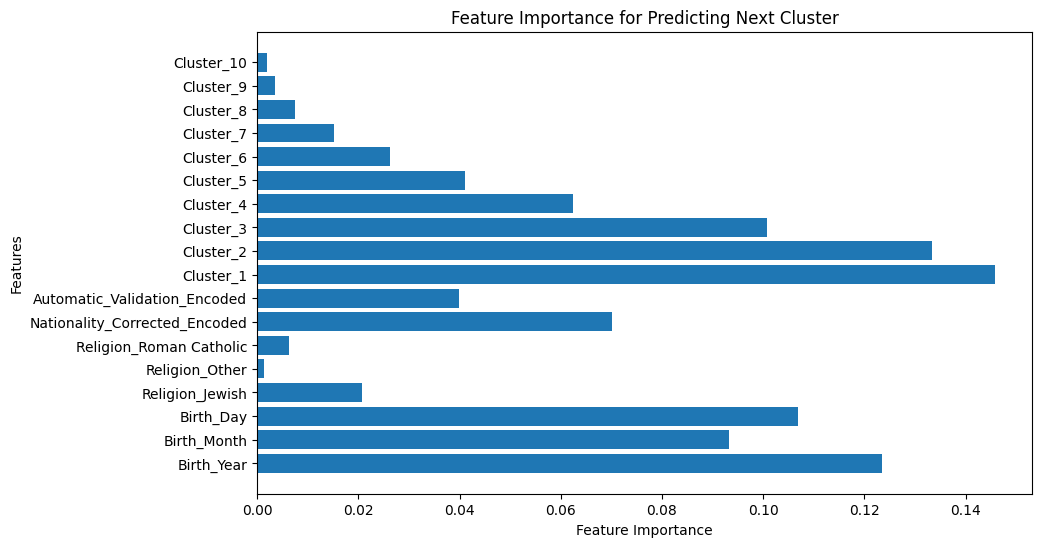

In [263]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Define features and target
features = [col for col in df.columns if col.startswith("Cluster_") or not col.endswith("Next_Cluster")]
X = df[features]
y = df["Next_Cluster"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature importance
importances = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for Predicting Next Cluster")
plt.show()
